In [ ]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import librosa
import json
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Initialization

In [ ]:
data = np.load('/content/drive/MyDrive/DL Sem 1 2021/Major Assignment/Lmao/classical.npy')

sc = MinMaxScaler()
max = np.max(np.abs(data))
data = data/max

x_train = data
print(x_train.shape)
x_train = torch.from_numpy(x_train).reshape(x_train.shape[0], 1, x_train.shape[1])
print(x_train.shape)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
input_size = x_train.shape[1]
latent_size = 4096
batch_size = 150
epochs = 30

(200, 45675)
torch.Size([200, 1, 45675])


In [ ]:
print(x_train[0])

tensor([[-0.0020,  0.0246,  0.0045,  ...,  0.0690,  0.1255,  0.1676]])


## Loss Functions

In [ ]:
L = nn.MSELoss()
def reproduction_loss(x, x_hat):
  return L(x_hat, x)

def KL_divergence(mean, log_var):
  return (-0.5)*torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

def total_loss(x_hat, x, mean, log_var):
    return reproduction_loss(x, x_hat) + KL_divergence(mean, log_var)

## Encoder Module

In [ ]:
class Encoder(nn.Module):
  def __init__(self, latent_size):
    super().__init__()
    self.Layer1 = nn.Conv1d(1, 16, 513, padding='same', padding_mode='circular')
    self.Pool1 = nn.MaxPool1d(10, return_indices=True)
    self.Layer2 = nn.Conv1d(16, 32, 257, padding='same', padding_mode='circular')
    self.Pool2 = nn.MaxPool1d(10, return_indices=True)
    self.Layer3 = nn.Conv1d(32, 64, 129, padding='same', padding_mode='circular')
    self.Pool3 = nn.MaxPool1d(10, return_indices=True)

    self.BN = nn.BatchNorm1d(64*45)

    self.LayerLM = nn.Linear(64*45, latent_size)
    self.LayerLV = nn.Linear(64*45, latent_size)

    self.sigmoid = nn.Sigmoid()
    self.relu = nn.ReLU()
    self.tanh = nn.Tanh()
    self.flatten = nn.Flatten(start_dim=1)

  def forward(self, inp):
    x = self.tanh(self.Layer1(inp))
    s1 = x.shape
    x, i1 = self.Pool1(x)
    x = self.tanh(self.Layer2(x))
    s2 = x.shape
    x, i2 = self.Pool2(x)
    x = self.tanh(self.Layer3(x))
    s3 = x.shape
    x, i3 = self.Pool3(x)

    x = self.flatten(x)
    x = self.BN(x)
    
    mean = self.LayerLM(x)
    var = self.LayerLV(x)

    return mean, var, i1, i2, i3, s1, s2, s3


## Decoder Module

In [ ]:
class Decoder(nn.Module):
  def __init__(self, latent_size):
    super().__init__()
    self.Layer1 = nn.Linear(latent_size, 64*45)
    # self.Drop = nn.Dropout(0.7)
    self.Pool1 = nn.MaxUnpool1d(10)
    self.Layer2 = nn.Conv1d(64, 32, 129, padding='same', padding_mode='circular')
    self.Pool2 = nn.MaxUnpool1d(10)
    self.Layer3 = nn.Conv1d(32, 16, 257, padding='same', padding_mode='circular')
    self.Pool3 = nn.MaxUnpool1d(10)
    self.Out = nn.Conv1d(16, 1, 513, padding='same', padding_mode='circular')

    self.relu = nn.ReLU()
    self.tanh = nn.Tanh()
    self.unflatten = nn.Unflatten(dim=1, unflattened_size=(64,45))

  def forward(self, inp):
    x = self.Layer1(inp[0])
    # x = self.Drop(x)
    x = self.unflatten(x)
    x = self.Pool1(x, inp[3], output_size=inp[6])
    x = self.tanh(self.Layer2(x))
    x = self.Pool1(x, inp[2], output_size=inp[5])
    x = self.tanh(self.Layer3(x))
    x = self.Pool1(x, inp[1], output_size=inp[4])
    x = self.tanh(self.Out(x))

    return x

## VAE Module

In [ ]:
class VAE(nn.Module):
  def __init__(self, latent_size):
    super().__init__()
    self.encoder = Encoder(latent_size)
    self.decoder = Decoder(latent_size)

  def reparameterization(self, mean, var):
    e = torch.randn(var.shape).to(device)
    return mean + var*e

  def forward(self, input):

    mean, var, i1, i2, i3, s1, s2, s3 = self.encoder(input)
    output = self.decoder((self.reparameterization(mean, var), i1, i2, i3, s1, s2, s3))

    return mean, var, output

  def Train(self, Data_Train, epochs, optimizer):

    history_loss_train = []

    for epoch in range(epochs):

      train_loss = 0

      input = Data_Train.float().to(device)
      optimizer.zero_grad()

      mean, var, output = self(input)

      loss = total_loss(output, input, mean, var)
      loss.backward()
      optimizer.step()

      train_loss += torch.sum(loss).item()

      history_loss_train.append(train_loss/len(Data_Train))
      print(f'Epoch: [{epoch +1}/ {epochs}] loss:{history_loss_train[-1]} ' )
    return (history_loss_train)

## Training

In [ ]:
model = VAE( latent_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)
history = model.Train(x_train, 50, optimizer)

Epoch: [1/ 50] loss:1093.396875 
Epoch: [2/ 50] loss:989.71171875 
Epoch: [3/ 50] loss:803.48421875 
Epoch: [4/ 50] loss:542.44546875 
Epoch: [5/ 50] loss:402.135 
Epoch: [6/ 50] loss:308.094921875 
Epoch: [7/ 50] loss:249.92357421875 
Epoch: [8/ 50] loss:215.48521484375 
Epoch: [9/ 50] loss:194.9540234375 
Epoch: [10/ 50] loss:180.36423828125 
Epoch: [11/ 50] loss:165.07091796875 
Epoch: [12/ 50] loss:147.58466796875 
Epoch: [13/ 50] loss:129.60654296875 
Epoch: [14/ 50] loss:113.3891015625 
Epoch: [15/ 50] loss:100.183125 
Epoch: [16/ 50] loss:89.94775390625 
Epoch: [17/ 50] loss:81.8064697265625 
Epoch: [18/ 50] loss:74.7613330078125 
Epoch: [19/ 50] loss:68.189208984375 
Epoch: [20/ 50] loss:61.9345849609375 
Epoch: [21/ 50] loss:56.1265966796875 
Epoch: [22/ 50] loss:50.9506005859375 
Epoch: [23/ 50] loss:46.4972021484375 
Epoch: [24/ 50] loss:42.71775390625 
Epoch: [25/ 50] loss:39.45922119140625 
Epoch: [26/ 50] loss:36.53597900390625 
Epoch: [27/ 50] loss:33.81908935546875 
Epo

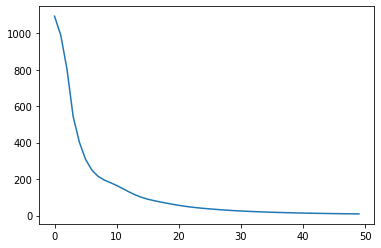

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(len(history)), history)
plt.show()

### Input Audio

In [ ]:
idx = 4
import IPython.display
sr = 3150
temp = x_train.reshape(x_train.shape[0], x_train.shape[2])
temp = temp*max
IPython.display.Audio(temp[idx], rate=sr)

### Generated Samples

In [ ]:
_, __, Gen = model(x_train.float().to(device))
temp = Gen.detach().to('cpu').reshape(x_train.shape[0], x_train.shape[2])
IPython.display.Audio(temp[idx], rate=sr)

In [ ]:
_, __, Gen = model(x_train.float().to(device))
temp = Gen.detach().to('cpu').reshape(x_train.shape[0], x_train.shape[2])
IPython.display.Audio(temp[idx+5], rate=sr)